Pré-processamento e Carregamento dos arquivos

In [ ]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss, classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.adapt import MLkNN
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
import os

In [ ]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Carregar os dados
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
test_labels_df = pd.read_csv('test_labels.csv')

In [ ]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
# Pré-processamento
# Juntar os rótulos de teste com os dados de teste
test_df = test_df.merge(test_labels_df, on='id')
# Remover linhas no conjunto de teste onde todos os rótulos são -1 (não disponíveis)
test_df = test_df[~((test_df['toxic'] == -1) & (test_df['severe_toxic'] == -1) &
                   (test_df['obscene'] == -1) & (test_df['threat'] == -1) &
                   (test_df['insult'] == -1) & (test_df['identity_hate'] == -1))]

In [ ]:
# Separar features e labels
X_train = train_df['comment_text']
y_train = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

X_test = test_df['comment_text']
y_test = test_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [ ]:
# Vetorização dos textos usando TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Reinicializar as ferramentas após o download
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
def advanced_preprocessing(text):
    # 1. Converter para minúsculas
    text = text.lower()

    # 2. Remover URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Remover números
    text = re.sub(r'\d+', '', text)

    # 4. Remover pontuação
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 5. Tokenização
    try:
        tokens = word_tokenize(text)
    except:
        # Fallback simples se a tokenização falhar
        tokens = text.split()

    # 6. Remover stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # 7. Lematização
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # 8. Remover tokens muito curtos
    tokens = [word for word in tokens if len(word) > 2]

    return ' '.join(tokens)

In [ ]:
# Testar com exemplo
sample_text = "Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
print("Exemplo antes do pré-processamento:")
print(sample_text)
print("\nExemplo após pré-processamento:")
print(advanced_preprocessing(sample_text))

Exemplo antes do pré-processamento:
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Exemplo após pré-processamento:
explanation edits made username hardcore metallica fan reverted werent vandalism closure gas voted new york doll fac please dont remove template talk page since retired


In [ ]:
!pip install pandarallel

  Preparing metadata (setup.py) ... done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16674 sha256=3e95d8034448be882bc7f942c80ecbf30d10d7d388c96f24d96f902e4ed3ddf3
  Stored in directory: /root/.cache/pip/wheels/b9/c6/5a/829298789e94348b81af52ab42c19d49da007306bbcc983827
Successfully built pandarallel


In [ ]:
# Aplicar a todo o dataset
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=max(1, os.cpu_count() - 1), progress_bar=True)
def safe_advanced_preprocessing(text):
    try:
        if pd.isnull(text) or str(text).strip() == "":
            return ""
        return advanced_preprocessing(str(text))
    except Exception as e:
        print(f"Erro ao processar texto: {str(text)[:50]}... - {str(e)}")
        return ""

# Aplicar com paralelização e cache
train_df['processed_text'] = train_df['comment_text'].parallel_apply(safe_advanced_preprocessing)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
# Verificar exemplos processados
print("\nAntes do pré-processamento:")
print(train_df['comment_text'].iloc[0])
print("\nDepois do pré-processamento:")
print(train_df['processed_text'].iloc[0])

# Estatísticas
original_lengths = train_df['comment_text'].str.len()
processed_lengths = train_df['processed_text'].str.len()
print(f"\nRedução média de tamanho: {(1 - processed_lengths.mean()/original_lengths.mean()):.1%}")


Antes do pré-processamento:
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Depois do pré-processamento:
explanation edits made username hardcore metallica fan reverted werent vandalism closure gas voted new york doll fac please dont remove template talk page since retired

Redução média de tamanho: 38.5%


In [ ]:
!pip install swifter
import swifter

train_df['processed_text'] = train_df['comment_text'].swifter.apply(safe_advanced_preprocessing)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=59dc6aaf5e320997a1ac9e735c7eb4337115bce82671b29c7a5922bef349baf9
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter


Pandas Apply:   0%|          | 0/159571 [00:00<?, ?it/s]

In [ ]:
# Verifique
print("Colunas disponíveis:", train_df.columns.tolist())
print("\nExemplo de texto processado:")
print(train_df[['comment_text', 'processed_text']].head())

# Verifique valores nulos/vazios
print("\nTextos vazios após processamento:", train_df['processed_text'].str.strip().eq('').sum())

Colunas disponíveis: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'processed_text']

Exemplo de texto processado:
                                        comment_text  \
0  Explanation\nWhy the edits made under my usern...   
1  D'aww! He matches this background colour I'm s...   
2  Hey man, I'm really not trying to edit war. It...   
3  "\nMore\nI can't make any real suggestions on ...   
4  You, sir, are my hero. Any chance you remember...   

                                      processed_text  
0  explanation edits made username hardcore metal...  
1  daww match background colour seemingly stuck t...  
2  hey man really trying edit war guy constantly ...  
3  cant make real suggestion improvement wondered...  
4                sir hero chance remember page thats  

Textos vazios após processamento: 88


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

# 1. Verificar/Criar a coluna processed_text
if 'processed_text' not in train_df.columns:
    tqdm.pandas()
    train_df['processed_text'] = train_df['comment_text'].progress_apply(
        lambda x: advanced_preprocessing(str(x)) if pd.notnull(x) else ""
    )

if 'processed_text' not in test_df.columns:
    test_df['processed_text'] = test_df['comment_text'].progress_apply(
        lambda x: advanced_preprocessing(str(x)) if pd.notnull(x) else ""
    )

# 2. Vetorização com TF-IDF
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=50000,
    ngram_range=(1, 2),
    min_df=10,
    max_df=0.8,
    sublinear_tf=True
)

# 3. Aplicar vetorização
try:
    X_train_processed = vectorizer.fit_transform(train_df['processed_text'])
    X_test_processed = vectorizer.transform(test_df['processed_text'])

    print("Vetorização concluída com sucesso!")
    print(f"Shape do treino: {X_train_processed.shape}")
    print(f"Shape do teste: {X_test_processed.shape}")

except KeyError:
    print("Erro: Verifique se a coluna 'processed_text' existe após o pré-processamento")
    print("Colunas disponíveis:", train_df.columns.tolist())

Pandas Apply:   0%|          | 0/63978 [00:00<?, ?it/s]

Vetorização concluída com sucesso!
Shape do treino: (159571, 50000)
Shape do teste: (63978, 50000)



# Modelagem com diferentes abordagens

1. Binary Relevance (abordagem mais simples)

In [ ]:
# Binary Relevance com Naive Bayes
binary_rel_clf = BinaryRelevance(MultinomialNB())
binary_rel_clf.fit(X_train_tfidf, y_train)
br_pred = binary_rel_clf.predict(X_test_tfidf)

print("Binary Relevance Performance:")
print(f"Hamming Loss: {hamming_loss(y_test, br_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, br_pred):.4f}")
print(classification_report(y_test, br_pred, target_names=y_test.columns))

Binary Relevance Performance:
Hamming Loss: 0.0263
Accuracy: 0.9011
               precision    recall  f1-score   support

        toxic       0.70      0.57      0.63      6090
 severe_toxic       0.46      0.34      0.39       367
      obscene       0.78      0.54      0.64      3691
       threat       0.00      0.00      0.00       211
       insult       0.72      0.46      0.56      3427
identity_hate       0.78      0.15      0.25       712

    micro avg       0.72      0.50      0.59     14498
    macro avg       0.57      0.34      0.41     14498
 weighted avg       0.71      0.50      0.58     14498
  samples avg       0.05      0.04      0.04     14498



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

2. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import ClassifierChain

model = ClassifierChain(LogisticRegression(solver='lbfgs', max_iter=1000))
model.fit(X_train_tfidf, y_train)

ClassifierChain(classifier=LogisticRegression(max_iter=1000),
                require_dense=[True, True])

3. Radom Forest

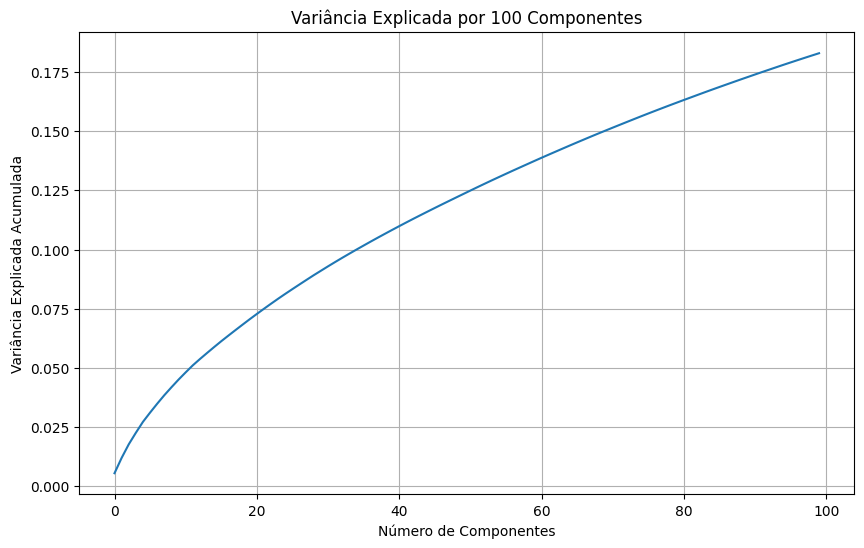

Variância total explicada com 100 componentes: 18.29%


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

n_components = 100

# 1. Redução de dimensionalidade
svd = TruncatedSVD(n_components=n_components)
X_train_reduced = svd.fit_transform(X_train_tfidf)
X_test_reduced = svd.transform(X_test_tfidf)

# Plot da variância acumulada
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title(f'Variância Explicada por {n_components} Componentes')
plt.grid()
plt.show()

print(f"Variância total explicada com {n_components} componentes: {np.sum(svd.explained_variance_ratio_):.2%}")

In [ ]:
rf_model = BinaryRelevance(
    RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        n_jobs=-1,  # Usa todos os núcleos do CPU
        random_state=42,
        class_weight='balanced'  # Importante para classes desbalanceadas
    )
)

In [ ]:
# 3. Treino e avaliação (com medição de tempo)
import time
start_time = time.time()

rf_model.fit(X_train_reduced, y_train)

train_time = time.time() - start_time
print(f"\nTempo de treinamento: {train_time:.2f} segundos")




Tempo de treinamento: 855.49 segundos


In [ ]:
# 4. Avaliação
from sklearn.metrics import classification_report

y_pred = rf_model.predict(X_test_reduced)
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=y_test.columns))


Relatório de Classificação:
               precision    recall  f1-score   support

        toxic       0.42      0.66      0.51      6090
 severe_toxic       0.07      0.79      0.12       367
      obscene       0.40      0.69      0.51      3691
       threat       0.05      0.55      0.10       211
       insult       0.32      0.65      0.43      3427
identity_hate       0.09      0.62      0.15       712

    micro avg       0.28      0.67      0.39     14498
    macro avg       0.22      0.66      0.30     14498
 weighted avg       0.36      0.67      0.46     14498
  samples avg       0.04      0.06      0.04     14498



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, hamming_loss, accuracy_score, classification_report
import numpy as np
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD

# Função para calcular e plotar métricas de um classificador
def evaluate_and_plot(classifier, X_test, y_test, name, X_test_reduced=None):
    # Previsões
    if X_test_reduced is not None:
        y_pred = classifier.predict(X_test_reduced)
    else:
        y_pred = classifier.predict(X_test)

    # Métricas
    h_loss = hamming_loss(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=y_test.columns, output_dict=True)

    print(f"\n{name} Performance:")
    print(f"Hamming Loss: {h_loss:.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=y_test.columns))

    # Matriz de confusão para cada classe
    plt.figure(figsize=(15, 10))
    for i, label in enumerate(y_test.columns):
        plt.subplot(2, 3, i+1)
        cm = confusion_matrix(y_test.iloc[:, i], y_pred.toarray()[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Não', 'Sim'], yticklabels=['Não', 'Sim'])
        plt.title(f'{name} - {label}')
        plt.xlabel('Previsto')
        plt.ylabel('Real')
    plt.tight_layout()
    plt.show()

    return {
        'name': name,
        'hamming_loss': h_loss,
        'accuracy': acc,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score']
    }

# Resultados dos classificadores
results = []


Binary Relevance com Naive Bayes

Naive Bayes Performance:
Hamming Loss: 0.0263
Accuracy: 0.9011
               precision    recall  f1-score   support

        toxic       0.70      0.57      0.63      6090
 severe_toxic       0.46      0.34      0.39       367
      obscene       0.78      0.54      0.64      3691
       threat       0.00      0.00      0.00       211
       insult       0.72      0.46      0.56      3427
identity_hate       0.78      0.15      0.25       712

    micro avg       0.72      0.50      0.59     14498
    macro avg       0.57      0.34      0.41     14498
 weighted avg       0.71      0.50      0.58     14498
  samples avg       0.05      0.04      0.04     14498



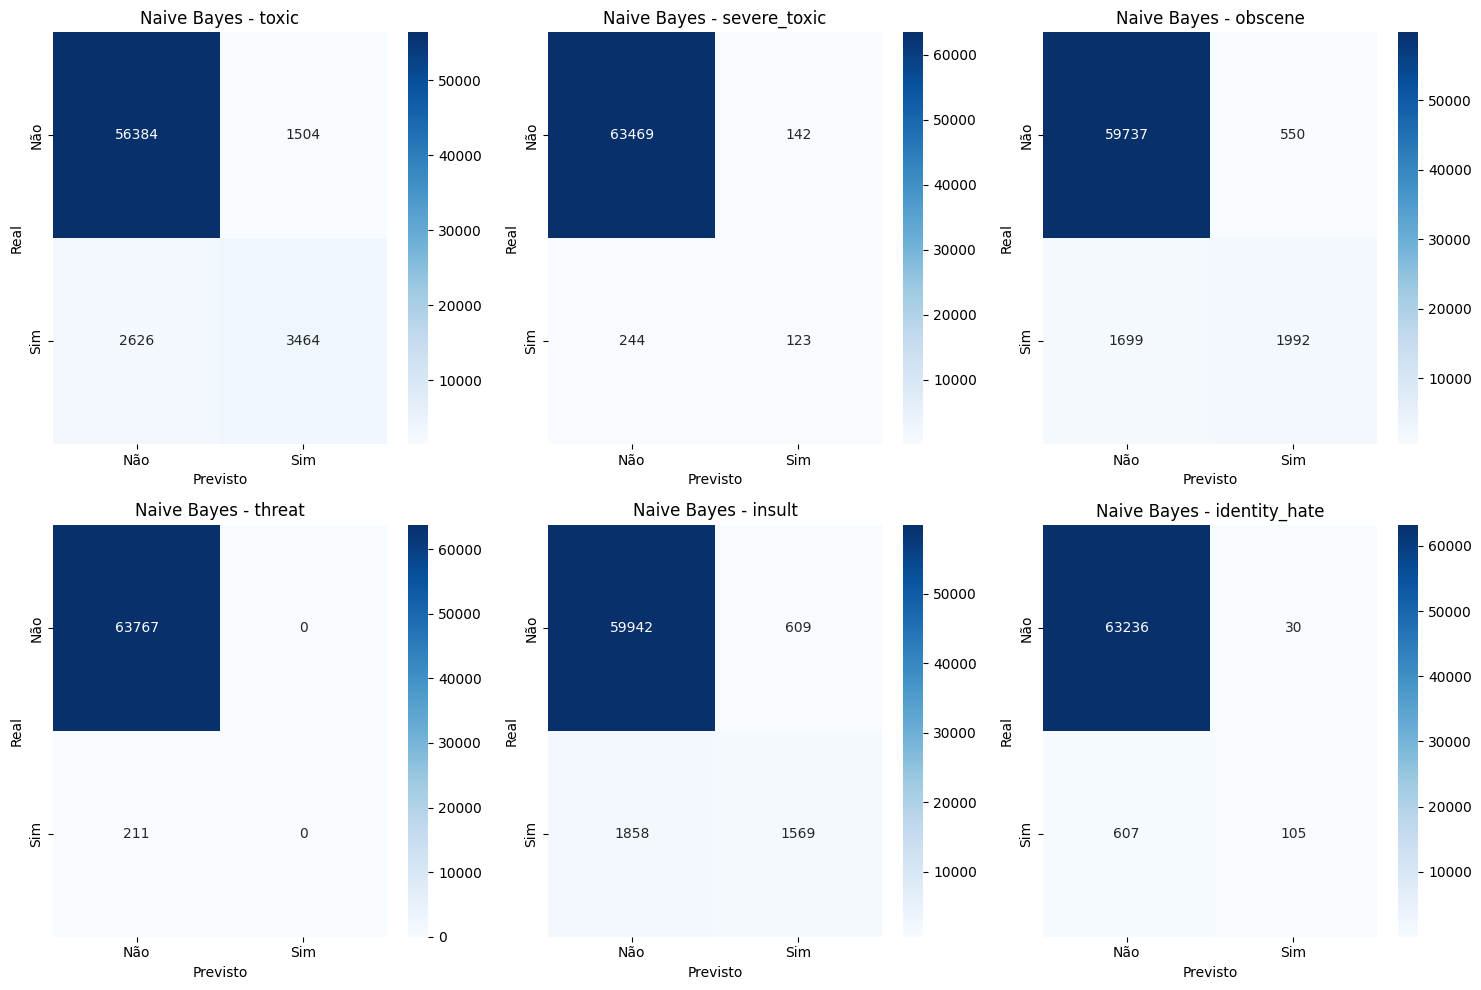

In [ ]:
# 1. Binary Relevance com Naive Bayes
print("\n" + "="*50)
print("Binary Relevance com Naive Bayes")
print("="*50)
binary_rel_clf = BinaryRelevance(MultinomialNB())
binary_rel_clf.fit(X_train_tfidf, y_train)
results.append(evaluate_and_plot(binary_rel_clf, X_test_tfidf, y_test, "Naive Bayes"))


Classifier Chain com Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


Logistic Regression Performance:
Hamming Loss: 0.0284
Accuracy: 0.8933
               precision    recall  f1-score   support

        toxic       0.63      0.72      0.67      6090
 severe_toxic       0.37      0.29      0.32       367
      obscene       0.66      0.68      0.67      3691
       threat       0.43      0.27      0.33       211
       insult       0.58      0.60      0.59      3427
identity_hate       0.68      0.26      0.37       712

    micro avg       0.62      0.64      0.63     14498
    macro avg       0.56      0.47      0.49     14498
 weighted avg       0.62      0.64      0.62     14498
  samples avg       0.06      0.06      0.06     14498



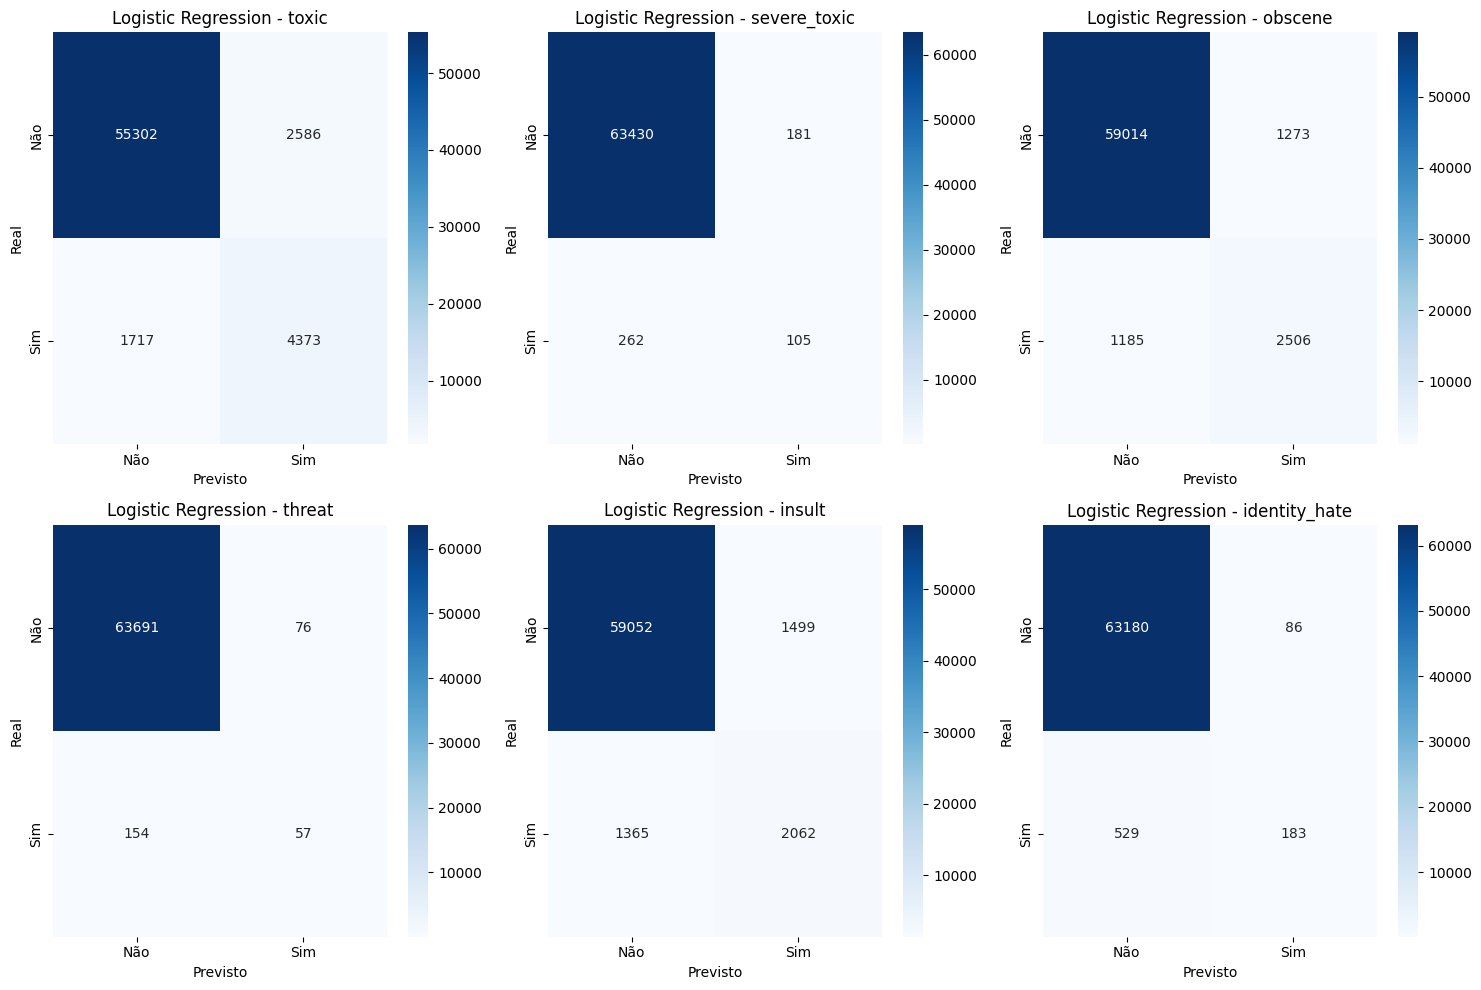

In [ ]:
# 2. Classifier Chain com Logistic Regression
print("\n" + "="*50)
print("Classifier Chain com Logistic Regression")
print("="*50)
logreg_model = ClassifierChain(LogisticRegression(solver='lbfgs', max_iter=1000))
logreg_model.fit(X_train_tfidf, y_train)
results.append(evaluate_and_plot(logreg_model, X_test_tfidf, y_test, "Logistic Regression"))


Binary Relevance com Random Forest


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


Random Forest Performance:
Hamming Loss: 0.0279
Accuracy: 0.9048
               precision    recall  f1-score   support

        toxic       0.76      0.45      0.57      6090
 severe_toxic       0.23      0.06      0.09       367
      obscene       0.79      0.46      0.58      3691
       threat       0.22      0.06      0.09       211
       insult       0.70      0.36      0.48      3427
identity_hate       0.51      0.06      0.11       712

    micro avg       0.75      0.40      0.52     14498
    macro avg       0.54      0.24      0.32     14498
 weighted avg       0.72      0.40      0.51     14498
  samples avg       0.04      0.03      0.03     14498



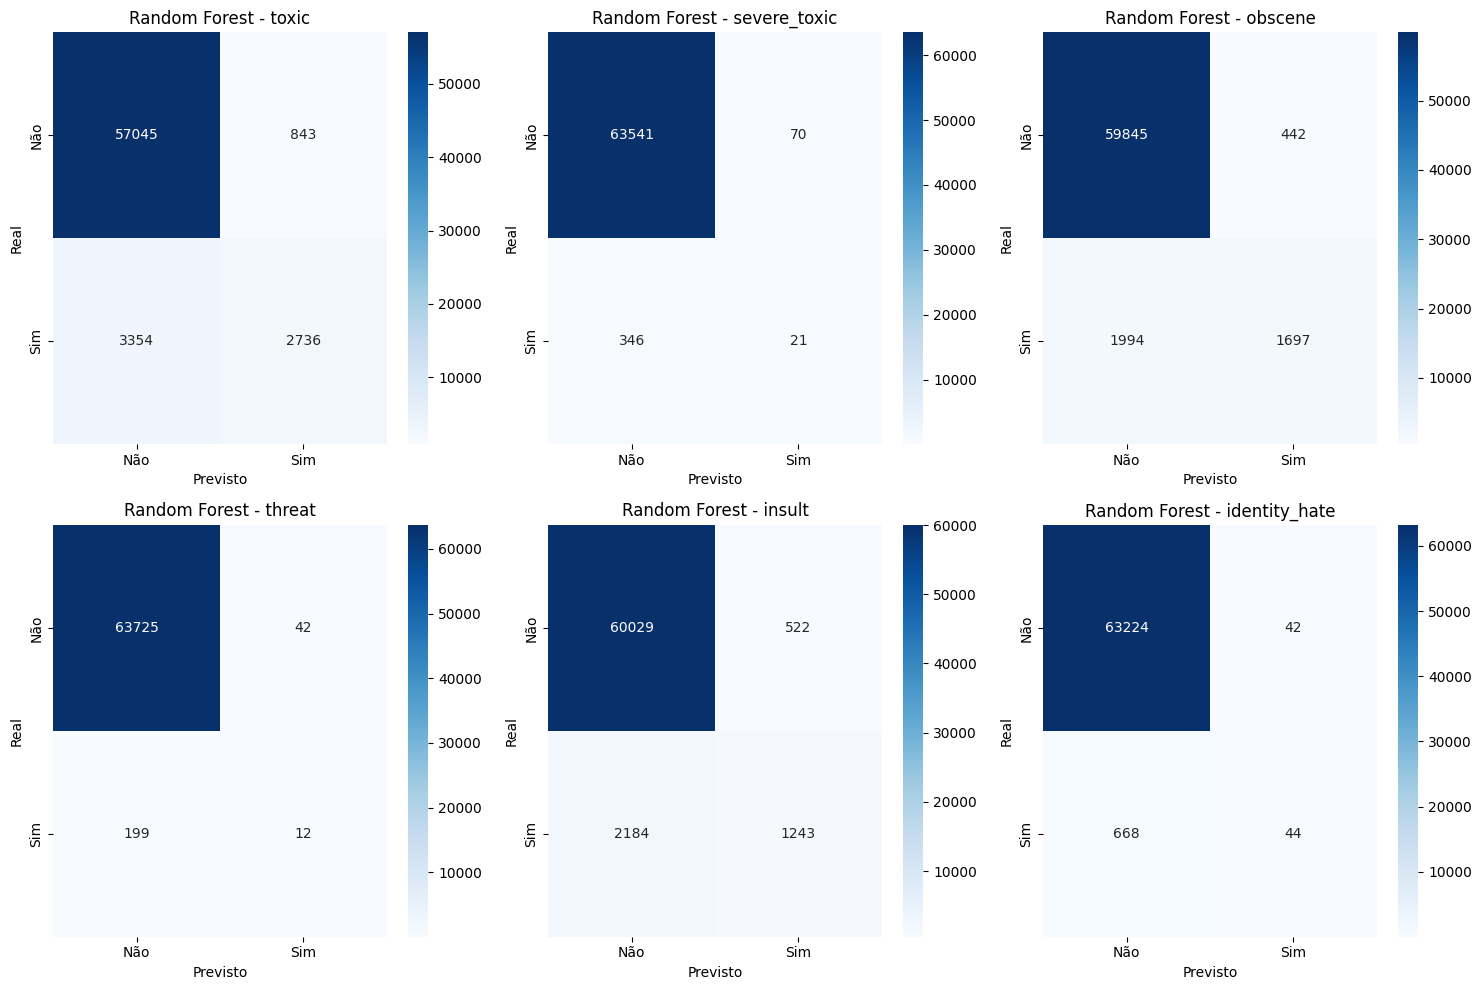

In [ ]:
# 3. Binary Relevance com Random Forest
print("\n" + "="*50)
print("Binary Relevance com Random Forest")
print("="*50)
svd = TruncatedSVD(n_components=500)
X_train_reduced = svd.fit_transform(X_train_tfidf)
X_test_reduced = svd.transform(X_test_tfidf)

rf_model = BinaryRelevance(RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=-1))
rf_model.fit(X_train_reduced, y_train)
results.append(evaluate_and_plot(rf_model, X_test_tfidf, y_test, "Random Forest", X_test_reduced))


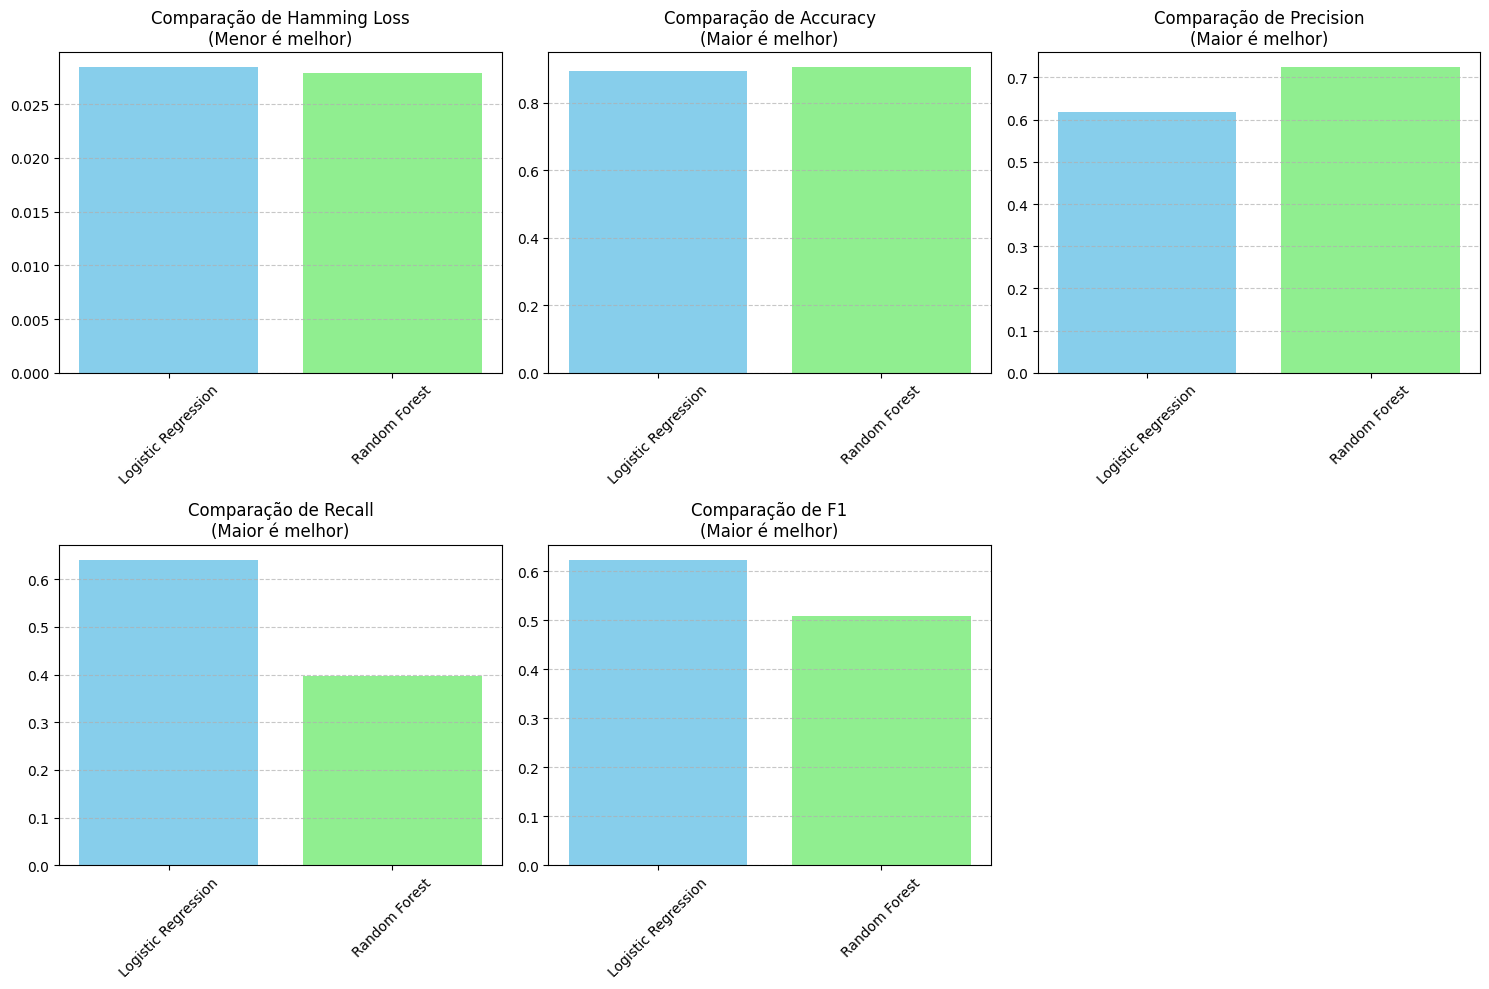

In [ ]:
# Gráfico comparativo final
metrics = ['hamming_loss', 'accuracy', 'precision', 'recall', 'f1']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    values = [res[metric] for res in results]
    names = [res['name'] for res in results]

    # Para Hamming Loss, quanto menor melhor
    if metric == 'hamming_loss':
        plt.bar(names, values, color=['skyblue', 'lightgreen', 'salmon'])
        plt.title(f'Comparação de {metric.replace("_", " ").title()}\n(Menor é melhor)')
    else:
        plt.bar(names, values, color=['skyblue', 'lightgreen', 'salmon'])
        plt.title(f'Comparação de {metric.replace("_", " ").title()}\n(Maior é melhor)')

    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Dataframe comparativo
import pandas as pd
results_df = pd.DataFrame(results)
results_df.set_index('name', inplace=True)
print("\nResumo Comparativo:")
display(results_df)


Resumo Comparativo:


,hamming_loss,accuracy,precision,recall,f1
name,,,,,
Logistic Regression,0.028429,0.893260,0.618604,0.640502,0.623141
Random Forest,0.027890,0.904764,0.723767,0.396813,0.508171


In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, hamming_loss

# Dicionário para armazenar todos os resultados
results = {
    'model': [],
    'accuracy': [],
    'hamming_loss': [],
    'avg_precision': [],
    'avg_recall': [],
    'avg_f1': [],
    'toxic_count': [],
    'severe_toxic_count': [],
    'obscene_count': [],
    'threat_count': [],
    'insult_count': [],
    'identity_hate_count': []
}

# Função para avaliar e salvar resultados
def evaluate_and_save(model, X_test, y_test, model_name, X_test_reduced=None):
    # Fazer previsões
    if X_test_reduced is not None:
        y_pred = model.predict(X_test_reduced)
    else:
        y_pred = model.predict(X_test)

    # Converter predições para array numpy
    y_pred_array = y_pred.toarray() if hasattr(y_pred, 'toarray') else y_pred

    # Calcular métricas globais
    accuracy = accuracy_score(y_test, y_pred)
    h_loss = hamming_loss(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Contar previsões positivas para cada classe
    pred_counts = y_pred_array.sum(axis=0)

    # Armazenar resultados
    results['model'].append(model_name)
    results['accuracy'].append(accuracy)
    results['hamming_loss'].append(h_loss)
    results['avg_precision'].append(precision)
    results['avg_recall'].append(recall)
    results['avg_f1'].append(f1)
    results['toxic_count'].append(pred_counts[0])
    results['severe_toxic_count'].append(pred_counts[1])
    results['obscene_count'].append(pred_counts[2])
    results['threat_count'].append(pred_counts[3])
    results['insult_count'].append(pred_counts[4])
    results['identity_hate_count'].append(pred_counts[5])

    # Salvar também as previsões completas
    pred_df = pd.DataFrame(y_pred_array, columns=y_test.columns)
    pred_df.to_csv(f'{model_name}_predictions.csv', index=False)

    return pred_counts

# 1. Avaliar Naive Bayes
nb_counts = evaluate_and_save(binary_rel_clf, X_test_tfidf, y_test, 'NaiveBayes')

# 2. Avaliar Logistic Regression
lr_counts = evaluate_and_save(logreg_model, X_test_tfidf, y_test, 'LogisticRegression')

# 3. Avaliar Random Forest
rf_counts = evaluate_and_save(rf_model, X_test_reduced, y_test, 'RandomForest', X_test_reduced)

# Criar DataFrame com todas as métricas
metrics_df = pd.DataFrame(results)

# Reorganizar colunas
cols_order = ['model', 'accuracy', 'hamming_loss', 'avg_precision', 'avg_recall', 'avg_f1',
              'toxic_count', 'severe_toxic_count', 'obscene_count',
              'threat_count', 'insult_count', 'identity_hate_count']
metrics_df = metrics_df[cols_order]

# Salvar métricas em CSV
metrics_df.to_csv('classification_metrics.csv', index=False)

# Criar e salvar DataFrame com contagens comparativas
counts_comparison = pd.DataFrame({
    'class': y_test.columns,
    'NaiveBayes': nb_counts,
    'LogisticRegression': lr_counts,
    'RandomForest': rf_counts
})

counts_comparison.to_csv('class_counts_comparison.csv', index=False)

print("Arquivos salvos com sucesso:")
print("- classification_metrics.csv: Contém todas as métricas de avaliação")
print("- *_predictions.csv: Contém as previsões de cada modelo")
print("- class_counts_comparison.csv: Contém a contagem de previsões positivas por classe")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Arquivos salvos com sucesso:
- classification_metrics.csv: Contém todas as métricas de avaliação
- *_predictions.csv: Contém as previsões de cada modelo
- class_counts_comparison.csv: Contém a contagem de previsões positivas por classe
